In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import math

if torch.cuda.is_available():
  dev = 'cuda'
  print("Cuda avaiable. Device used to train the model:", dev)
else: 
  dev = 'cpu'
  print("Cuda not avaiable. Device used to train the model:", dev)


Cuda avaiable. Device used to train the model: cuda


# **A harmonic series dataset** (from: *sequential_things.ipynb* by **Franco Caspe**)

This dataset generates a periodic wave given a harmonic distribution and a number of cycles we want to compute.

In [3]:
# First version of HarmonicSeriesDataset
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(n_freqs)
        self.freqs = torch.linspace(start=0, end=n_freqs-1, steps=n_freqs)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = 0
        
        self.phases += 2*np.pi*self.freqs/self.sample_rate
        sample = torch.sum(self.harmonics*torch.sin(self.phases))
        return sample

# Dataset 
Let's generate a dataset and plot its content.

240
240
Samples.shape torch.Size([32, 240])
Samples.shape permuted torch.Size([1, 240, 32])


/tmp/ipykernel_11932/1425330012.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.harmonics = torch.tensor(harmonics)


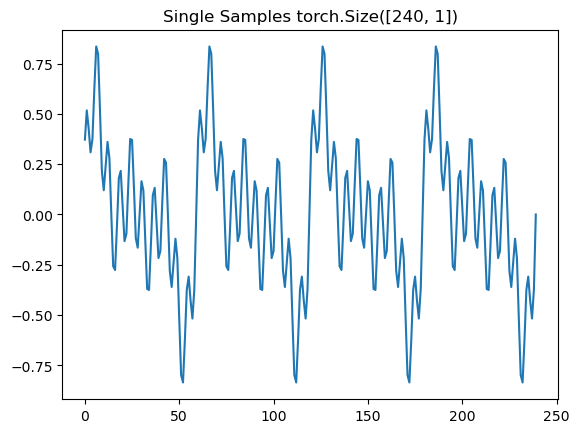

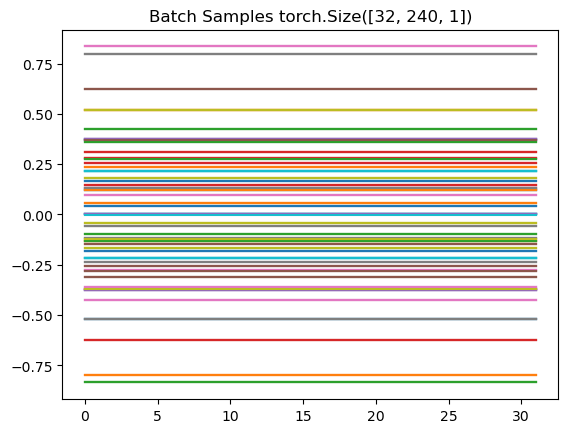

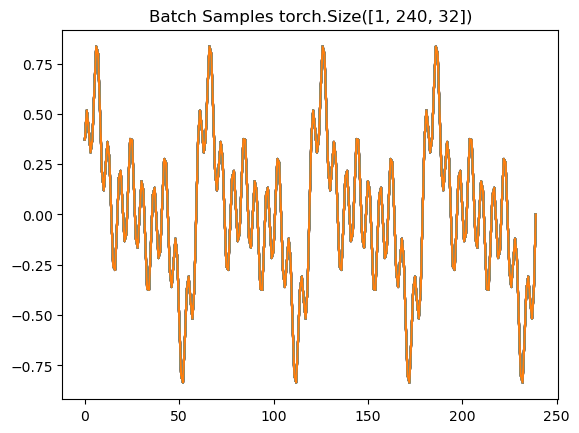

In [29]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
batch_size = 32
dataset = HarmonicSeriesDataset(harmonics,n_periods)
dataloader = torch.utils.data.DataLoader(dataset)

# Sample storage to plot
signal_len = len(dataloader)
print(period_len*n_periods)
print(signal_len)

samples = torch.zeros(batch_size,signal_len)

for i,sample in enumerate(dataloader):
      samples[:,i] = sample
      
train_samples = samples.unsqueeze(2)

# Plot dataset examples
print("Samples.shape",samples.shape)
print("Samples.shape permuted",train_samples.permute(2,1,0).shape)
plt.plot(train_samples[0,:,:].detach().numpy())
plt.title("Single Samples {}".format(train_samples[0,:,:].shape))
plt.show()
plt.plot(train_samples[:,:,0].detach().numpy())
plt.title("Batch Samples {}".format(train_samples.shape))
plt.show()
plt.plot(train_samples[:,:,0].permute(1,0).detach().numpy())
plt.title("Batch Samples {}".format(train_samples.permute(2,1,0).shape))
plt.show()

# **Gated Recurrent Unit (GRU)**

In [30]:
class GRUmodel(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, num_layers=1):
    super(GRUmodel, self).__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    # GRU (input)
    self.gru = nn.GRU(input_size, hidden_dim, num_layers=num_layers, batch_first=True)
    # Fully connected (output)
    self.lin = nn.Linear(hidden_dim, output_size)
    
  # Forward method
  def forward(self, seq):

    input = seq  # input.shape = (N,L,input_size)
    
    out, hidden = self.gru(input) # out.shape = (L,hidden_dim)...hidden.shape = (num_layers, hidden_dim)
    out = self.lin(out) # out.shape = (1,1)
    return out


In [31]:
def gru_evaluate_on_data(net, eval_data, target, device, plot=False):
  
  eval_data = eval_data.to(device) # ([N,L,1])
  target = target.to(device) # ([N,L,1])
  L = target.shape[1] # sequence length
  batch_size = target.shape[0] # batch size
  seq = torch.ones([batch_size,L,1]).to(device) # ([N,L,1])

  with torch.no_grad():
    pred = net(seq)
  # Calculate evaluation loss
  eval_loss = torch.sum(torch.abs(target-pred))

  # Plotting results
  if(plot):
    fig, ax = plt.subplots()
    print("[TEST ON DATA] Eval loss {}".format(eval_loss))
    ax.plot(target[0,:,:].detach().cpu().numpy())
    ax.plot(pred[0,:,:].detach().cpu().numpy())
    plt.show()

  return eval_loss
  
def gru_train(net, epochs, train_samples, device):
  
  net.train()

  # Define Loss, Optimizer, ecc.
  criterion = nn.L1Loss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  best_eval_loss = np.inf

  train_samples = train_samples.to(device) #([N,L,1])
  target = train_samples.to(device) #([N,L,1]) 
  L = target.shape[1] # sequence length
  n_batches = target.shape[0] # batch size
  epochs_loss = np.zeros(epochs)

  for epoch in range(epochs): 
    optimizer.zero_grad()
    running_loss = 0.0
    seq = torch.ones([n_batches,L,1]).to(device) # ([N,L,1])
    prediction = net(seq)
    loss = criterion(prediction, target) # Calculate loss
    loss.backward() # Backpropagation and calculates gradients
    optimizer.step() # Updates the weights
    # Print statistics
    running_loss += loss.item() # To calculate epochs' mean loss
    plot = True if (epoch%(epochs/16)==0) else False
    eval_loss = gru_evaluate_on_data(net, train_samples, target, device, plot=plot)
    
    epochs_loss[epoch] = eval_loss # For plotting loss during epochs

    if eval_loss < best_eval_loss:
      best_eval_loss = eval_loss
      torch.save(net.state_dict(), 'best_gru.pt')

    if (epoch%(epochs/20) == 0):
        print('Epoch: {}/{} .............'.format(epoch, epochs), end=' ')
        print("Train Loss: {:.4f} - Best Eval {:.4f}".format(running_loss, best_eval_loss))
    
    running_loss = 0.0

  print("---------- FINISHED TRAINING ----------")

  # Print Eval Loss
  x_ = np.linspace(0, epochs-1, epochs)
  y_ = epochs_loss
  yhat_ = signal.savgol_filter(y_, 101, 3) # Savitzky-Golay filter for smoothing

  fig, ax = plt.subplots()
  ax.plot(x_, y_)
  ax.plot(x_, yhat_)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Eval Loss') 
  # ax.grid(True) 
  plt.show()

In [32]:
def train_and_test_GRU(hidden_size, n_hidden_layers, train_data, target, epochs, device):
  train_len = train_data.size()[2]

  net = GRUmodel(1,1,hidden_size, n_hidden_layers)
  net = net.to(device)

  model_parameters = filter(lambda p: p.requires_grad, net.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("[INFO] Number of parameters: {}".format(params))
  
  # TRAINING
  gru_train(net, epochs, train_data, device)

  # TEST
  net.load_state_dict(torch.load('best_gru.pt'))  
  net.eval()
  gru_evaluate_on_data(net, train_data, target, device, plot=True)
  
  return net


[INFO] Number of parameters: 12929
[TEST ON DATA] Eval loss 2196.1064453125


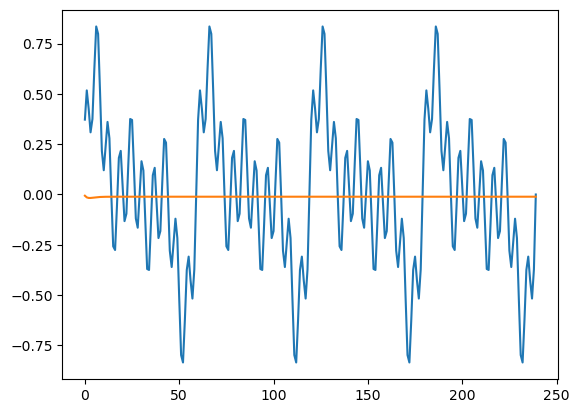

Epoch: 0/10000 ............. Train Loss: 0.2876 - Best Eval 2196.1064
Epoch: 500/10000 ............. Train Loss: 0.2687 - Best Eval 1931.4639
[TEST ON DATA] Eval loss 2020.23779296875


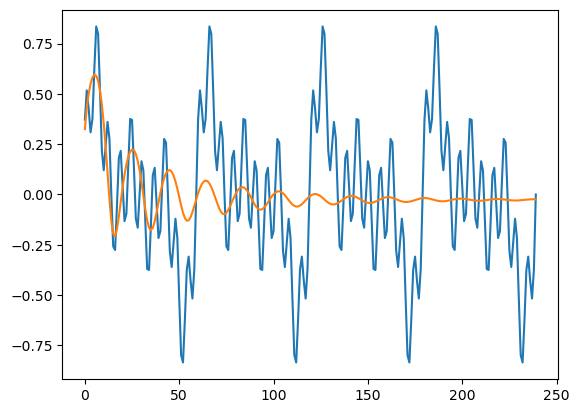

Epoch: 1000/10000 ............. Train Loss: 0.2683 - Best Eval 1900.6248
[TEST ON DATA] Eval loss 2055.0751953125


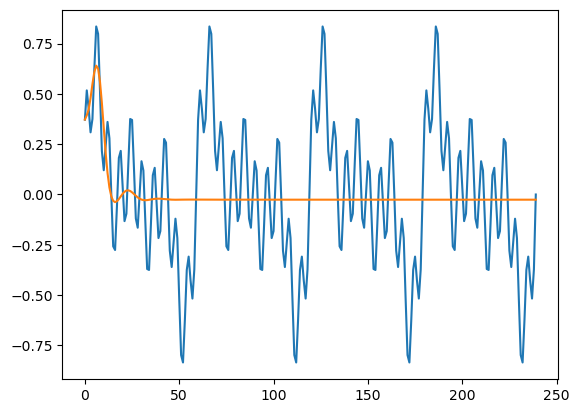

Epoch: 1500/10000 ............. Train Loss: 0.2824 - Best Eval 1894.2488
[TEST ON DATA] Eval loss 2018.539306640625


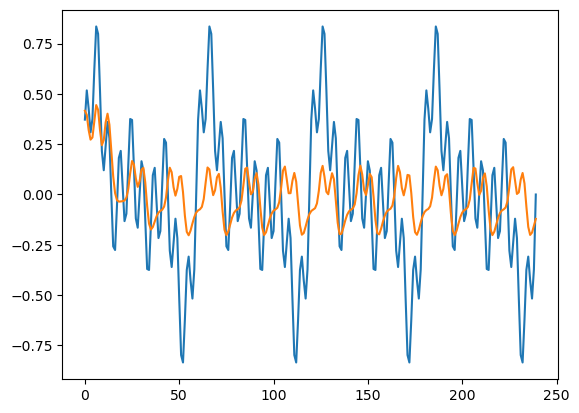

Epoch: 2000/10000 ............. Train Loss: 0.2297 - Best Eval 1668.7036
[TEST ON DATA] Eval loss 1588.928955078125


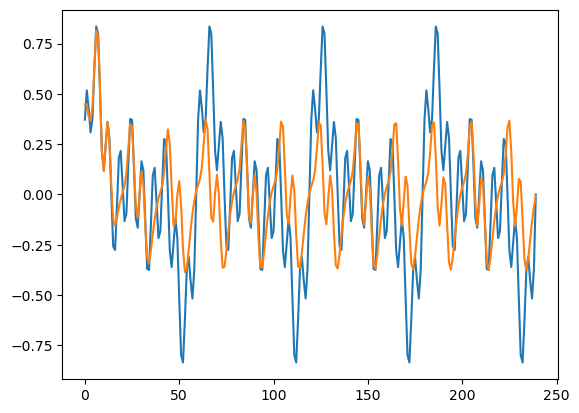

Epoch: 2500/10000 ............. Train Loss: 0.2187 - Best Eval 1583.4858
Epoch: 3000/10000 ............. Train Loss: 0.2144 - Best Eval 1236.2031
[TEST ON DATA] Eval loss 1619.514892578125


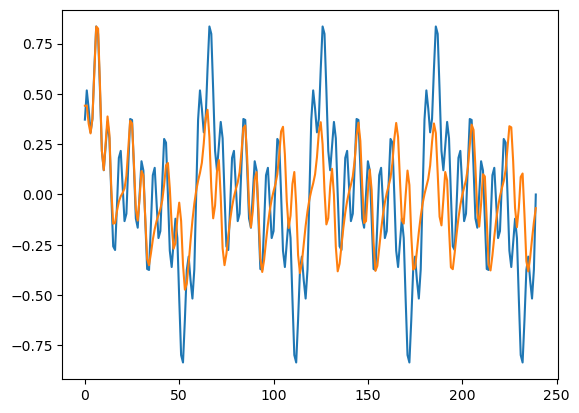

Epoch: 3500/10000 ............. Train Loss: 0.0727 - Best Eval 532.0259
[TEST ON DATA] Eval loss 564.3558349609375


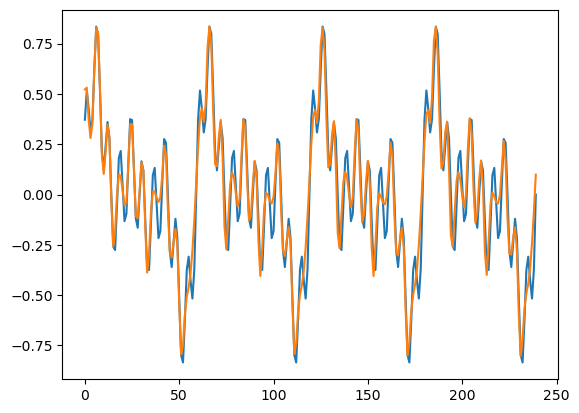

Epoch: 4000/10000 ............. Train Loss: 0.0430 - Best Eval 290.6219
[TEST ON DATA] Eval loss 275.6527099609375


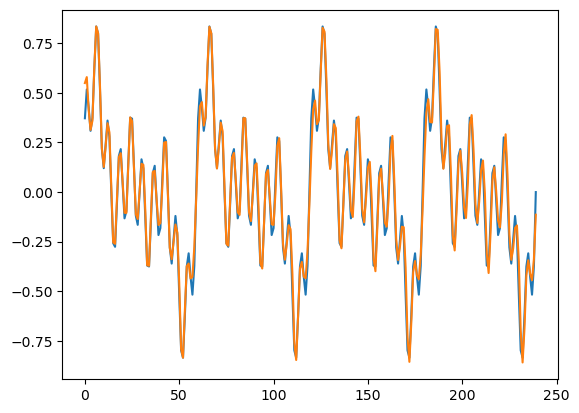

Epoch: 4500/10000 ............. Train Loss: 0.0781 - Best Eval 177.1294
[TEST ON DATA] Eval loss 880.0040283203125


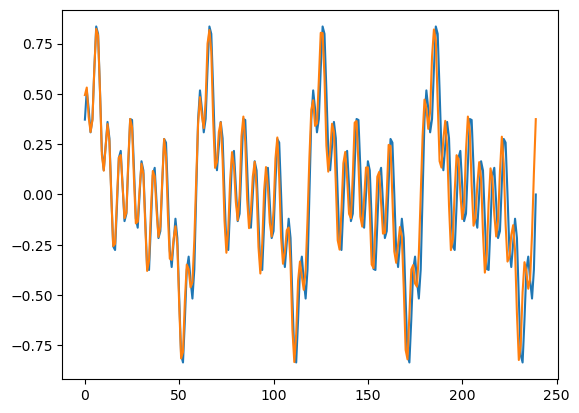

Epoch: 5000/10000 ............. Train Loss: 0.0861 - Best Eval 118.0498
Epoch: 5500/10000 ............. Train Loss: 0.0426 - Best Eval 103.0881
[TEST ON DATA] Eval loss 406.51690673828125


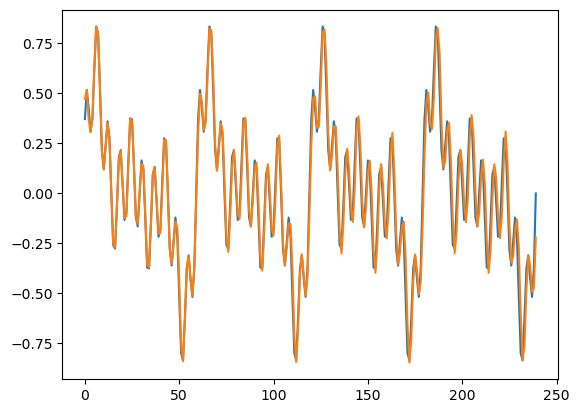

Epoch: 6000/10000 ............. Train Loss: 0.1194 - Best Eval 68.0555
[TEST ON DATA] Eval loss 132.32290649414062


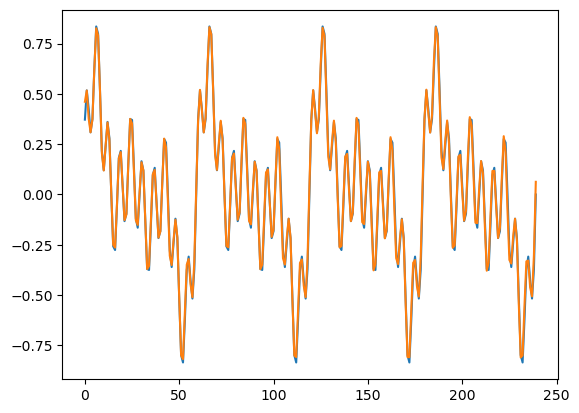

Epoch: 6500/10000 ............. Train Loss: 0.0390 - Best Eval 52.7427
[TEST ON DATA] Eval loss 100.23699951171875


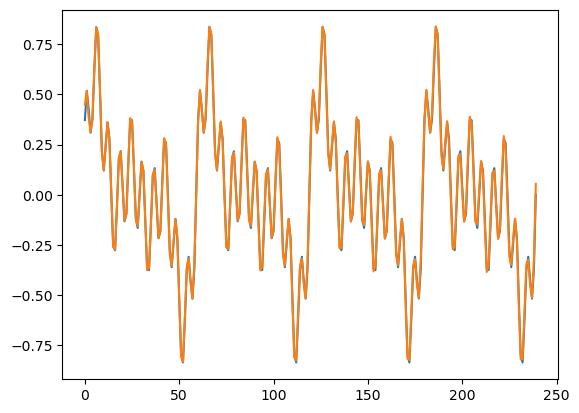

Epoch: 7000/10000 ............. Train Loss: 0.0139 - Best Eval 50.6864
[TEST ON DATA] Eval loss 257.6657409667969


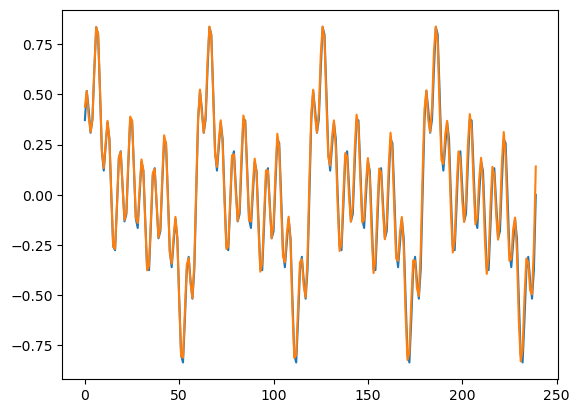

Epoch: 7500/10000 ............. Train Loss: 0.0324 - Best Eval 32.0232
Epoch: 8000/10000 ............. Train Loss: 0.0121 - Best Eval 32.0232
[TEST ON DATA] Eval loss 120.0953369140625


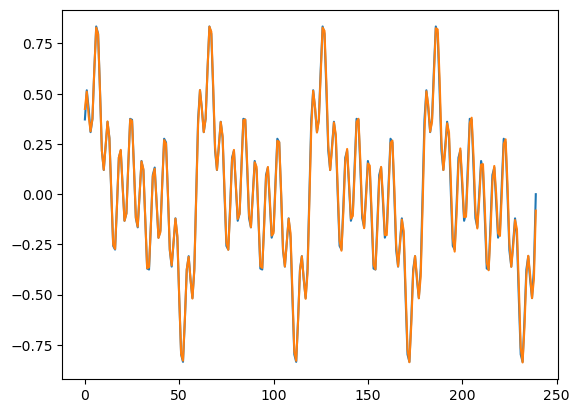

Epoch: 8500/10000 ............. Train Loss: 0.0127 - Best Eval 32.0232
[TEST ON DATA] Eval loss 237.60549926757812


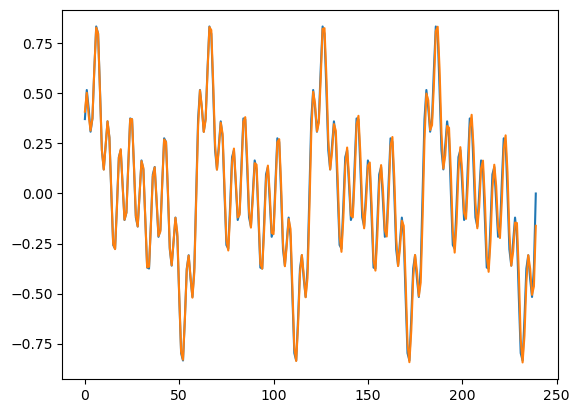

Epoch: 9000/10000 ............. Train Loss: 0.0261 - Best Eval 32.0232
[TEST ON DATA] Eval loss 158.01353454589844


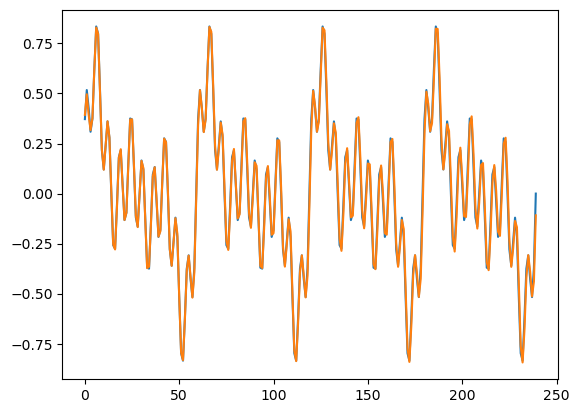

Epoch: 9500/10000 ............. Train Loss: 0.0199 - Best Eval 32.0232
---------- FINISHED TRAINING ----------


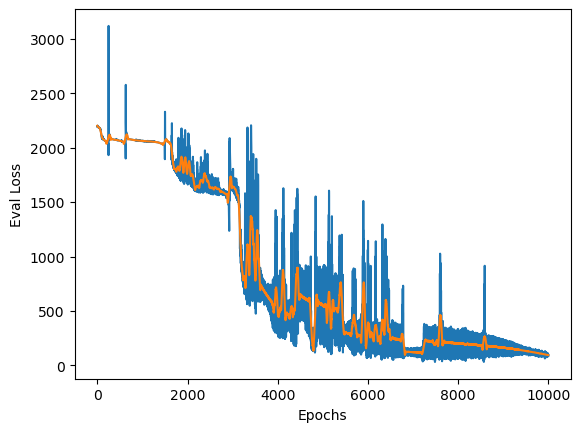

[TEST ON DATA] Eval loss 32.023170471191406


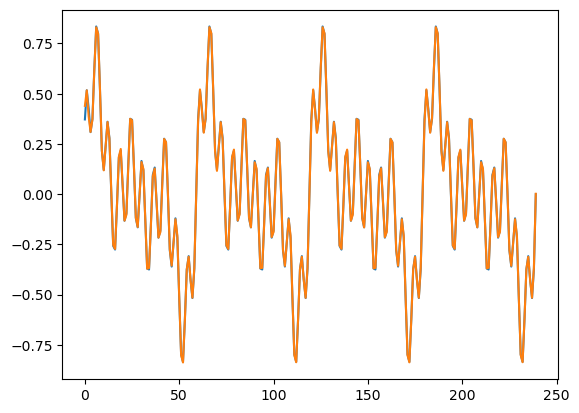

In [33]:
GRUnet = train_and_test_GRU(hidden_size=64, n_hidden_layers=1, train_data=train_samples, target=train_samples, epochs=10000, device=dev)

# **Testing Trained GRUnet**

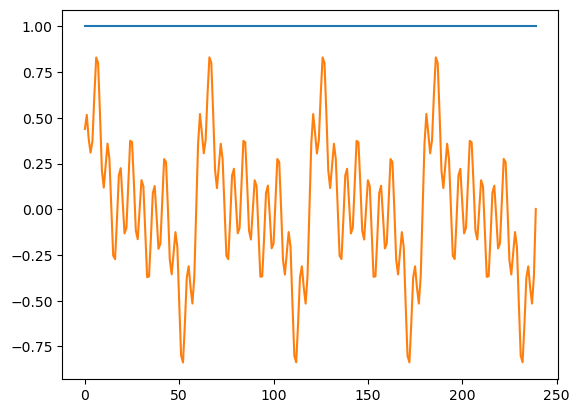

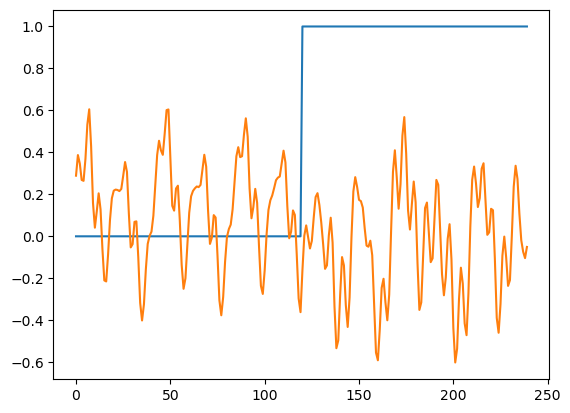

In [36]:
seq = torch.ones(1,240,1)
seq = seq.to(dev)
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().cpu().numpy())
plt.plot(signal[0,:,:].detach().cpu().numpy())
plt.show()

seq = torch.ones(1,240,1)
seq[:,0:120,:] = 0
seq = seq.to(dev)
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().cpu().numpy())
plt.plot(signal[0,:,:].detach().cpu().numpy())
plt.show()